<h1>
<center>Predict NYSE Volume using Time Series</center>
</h1>

<h1>
<center>Avery Lee</center>
</h1>

# Random forest for time series data

Only 3 time series in this dataset will be used: `DJ_return` ($a_t$), `log_volatility` ($b_t$), and `log_volume` ($c_t$). 

We want to predict the 1-step ahead value of `log_volume` $c_{t+1}$ using the previous values of this variable and the other two variables (`DJ_return` and `log_volatility`) up to 5 lags. So the features are $c_{t},\dots,c_{t-4},b_{t},\dots,b_{t-4},a_{t},\dots,a_{t-4}$.

In [1]:
import os
import pandas as pd
data = pd.read_csv("/Users/averylee/Desktop/CFRM 421/HW 2/NYSE.csv")
data = data.drop(columns=['date', 'day_of_week', 'train'])
series_len = len(data)
data.head(7)

,DJ_return,log_volume,log_volatility
0,-0.004461,0.032573,-13.127403
1,0.007813,0.346202,-11.749305
2,0.003845,0.525306,-11.665609
3,-0.003462,0.210182,-11.626772
4,0.000568,0.044187,-11.728130
5,-0.010824,0.133246,-10.872526
6,0.000124,-0.011528,-10.977797


In [2]:
data.shape

(6051, 3)

Create the feature matrix `X` and the target variable `y`.

In [3]:
import numpy as np

def concat_rows_into_one(rows):
    rows_list = [rows.iloc[i] for i in range(len(rows))]
    return pd.concat(rows_list, ignore_index=True)

def ts_split(ts, feature_steps, target_steps):
    n_obs = len(ts) - feature_steps - target_steps + 1
    X = np.array([concat_rows_into_one(ts[idx:idx+feature_steps]) for idx in range(n_obs)])
    y = np.array([ts['log_volume'][idx+feature_steps : idx+feature_steps+target_steps] for idx in range(n_obs)])
    return X, y

X, y = ts_split(data, feature_steps=5, target_steps=1) # lag 5, predict 1 step ahead value 

X.shape, y.shape

((6046, 15), (6046, 1))

In [4]:
pd.DataFrame(X[0:2])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,-0.004461,0.032573,-13.127403,0.007813,0.346202,-11.749305,0.003845,0.525306,-11.665609,-0.003462,0.210182,-11.626772,0.000568,0.044187,-11.728130
1,0.007813,0.346202,-11.749305,0.003845,0.525306,-11.665609,-0.003462,0.210182,-11.626772,0.000568,0.044187,-11.728130,-0.010824,0.133246,-10.872526


In [5]:
pd.DataFrame(y[0:2])

,0
0,0.133246
1,-0.011528


Let's fit a random forest to predict the 1-step ahead value of `log_volume`. Use 3-fold time series CV, with the test set split 50% into a validation set and 50% into the actual test set, to tune the hyperparameters `n_estimators` taking the values  100, 500, 750, and the cost-complexity pruning parameter $\alpha$ taking the values $10^{-k}$, $k=0,1,\dots,9$. The performance measure is RMSE. 

As we can see below, the best hyperparameters are 1e-05 (alpha), 500 (n_estimator)


In [6]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# hyperparameter combinations 
ccp_alpha_list = [10**(-k) for k in range(10)]
n_estimators_list = [100,500,750]

def time_series_valid_test(X, y, n_split, valid_or_test, optimal_par=None):
    tscv = TimeSeriesSplit(n_splits=n_split)
    rf_rmse = []
    i = 0
    for train_index, test_index in tscv.split(X):
        i += 1
        # Break test set into 50% validation set, 50% test set
        break_test_ind = int(test_index[0] + 0.5*(test_index[-1]-test_index[0]))
        valid_index = np.array(list(range(test_index[0],break_test_ind)))
        test_index = np.array(list(range(break_test_ind,test_index[-1])))

        # Split
        X_train, X_valid, X_test = X[train_index], X[valid_index], X[test_index]
        y_train, y_valid, y_test = y[train_index], y[valid_index], y[test_index]

        # Tuning
        if valid_or_test == "valid":
            for alpha in ccp_alpha_list:
                for n_estimators in n_estimators_list:
                    model_rf = RandomForestRegressor(random_state=42, 
                               ccp_alpha=alpha, n_estimators=n_estimators, n_jobs=-1)
                    model_rf.fit(X_train, y_train.ravel())
                    y_val_rf = model_rf.predict(X_valid)
                    rf_rmse.append(np.sqrt(mean_squared_error(y_valid, y_val_rf)))
        
        # Evalulate on test set
        if valid_or_test == "test":
            model_rf = RandomForestRegressor(random_state=42, 
                       ccp_alpha=optimal_par[0], n_estimators=optimal_par[1], n_jobs=-1)
            model_rf.fit(X_train, y_train.ravel())
            y_test_rf = model_rf.predict(X_test)
            rf_rmse.append(np.sqrt(mean_squared_error(y_test, y_test_rf)))
            importances = model_rf.feature_importances_
            
            # Plot the prediction for the last CV fold
            if i == n_split:
                plt.plot(range(series_len-test_index.size,series_len),
                         y_test_rf, label="1-step ahead prediction")
                plt.plot(range(series_len-test_index.size,series_len),
                         y_test, label="True value")
                plt.legend(loc="upper left")
    
    # Average RMSE over CV folds
    if valid_or_test == "valid":
        rf_rmse = np.mean(np.array(rf_rmse).reshape(
            n_split, len(ccp_alpha_list)*len(n_estimators_list)), axis=0)
        return rf_rmse
    if valid_or_test == "test":
        rf_rmse = np.mean(rf_rmse)
        return rf_rmse, y_test_rf, importances

In [7]:
# validation
rf_rmse_val = time_series_valid_test(X, y, 3, 'valid')
ind = 0
min_rmse, optimal_alpha, optimal_n_estimator = rf_rmse_val[0], ccp_alpha_list[0], n_estimators_list[0]
for alpha in ccp_alpha_list:
    for n_estimators in n_estimators_list:
        if rf_rmse_val[ind] < min_rmse:
            min_rmse, optimal_alpha, optimal_n_estimator = rf_rmse_val[ind], alpha, n_estimators
        print(["(alpha, n_estimators):",[alpha, n_estimators]])
        print(rf_rmse_val[ind])
        ind += 1

print(f'optimal alpha, optimal n estimator: {optimal_alpha}, {optimal_n_estimator}')

['(alpha, n_estimators):', [1, 100]]
0.2358102502325389
['(alpha, n_estimators):', [1, 500]]
0.23583279057420017
['(alpha, n_estimators):', [1, 750]]
0.23582412722547763
['(alpha, n_estimators):', [0.1, 100]]
0.2358102502325389
['(alpha, n_estimators):', [0.1, 500]]
0.23583279057420017
['(alpha, n_estimators):', [0.1, 750]]
0.23582412722547763
['(alpha, n_estimators):', [0.01, 100]]
0.1931776501341703
['(alpha, n_estimators):', [0.01, 500]]
0.19289278821198516
['(alpha, n_estimators):', [0.01, 750]]
0.1928692930007393
['(alpha, n_estimators):', [0.001, 100]]
0.1742571823815323
['(alpha, n_estimators):', [0.001, 500]]
0.1741139415851224
['(alpha, n_estimators):', [0.001, 750]]
0.1740238054718721
['(alpha, n_estimators):', [0.0001, 100]]
0.16141953119324295
['(alpha, n_estimators):', [0.0001, 500]]
0.16110542582680856
['(alpha, n_estimators):', [0.0001, 750]]
0.1611824219097941
['(alpha, n_estimators):', [1e-05, 100]]
0.16109798527211847
['(alpha, n_estimators):', [1e-05, 500]]
0.1604738

Using the same time series split, we can compute the RMSE of the best fitting model on the test set, and include a plot of the true values and predicted values on the test set of the last fold (the fold closest to the current time) of the CV.

0.18701414595137536

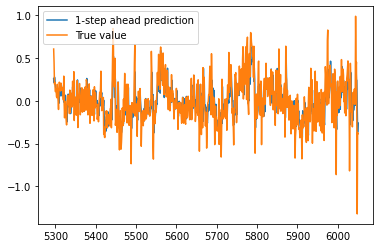

In [8]:
# testing 
rf_rmse_test, y_test_rf, importances_test = time_series_valid_test(X, y, 3, 'test', [optimal_alpha, optimal_n_estimator])
rf_rmse_test

It is often useful to check that your model is not worse than a very simple method of prediction. Let's try computing the RMSE of a model that simply predicts the 1-step ahead value of `log_volume` $c_{t+1}$ as the current value $c_t$, and compare this to the best fitting random forest model.

The above has lower RMSE so we can say for this example that that one is working better. However, there is not too much of a difference between that RMSE (0.18701414) vs the simple one below (0.18890174). So if time is more valuable than accuracy, it might be worth to just use the simple method. 

In [9]:
simple_rmse = np.sqrt(mean_squared_error(list(data['log_volume'][0:-1]), list(data['log_volume'][1:])))
simple_rmse

0.18890174010847652

If we compute the feature importances of the best fitting model, we can see that the most important feature is log_volume_t-0 and its feature importance value is 0.567137

In [10]:
features = np.array([['DJ_return_t-'+str(i), 'log_volume_t-'+str(i), 'log_volatility-'+str(i)] for i in range(4,-1,-1)]).flatten()
print(f'feature, importance value: {features[np.argmax(importances_test)]}, {max(importances_test)}')

feature, importance value: log_volume_t-0, 0.5671372231740255
